# Humans Segmentation


## Intro

This is net to perform humans segmentation from images.

**Dataset used:** https://github.com/VikramShenoy97/Human-Segmentation-Dataset contains 300 images.

**Model used:**U-Net with about 7mil parameters. Check it out in *model.png* file and in summary logs after running 4th cell.

At the end is the section to make predictions on images from Your own web cam.

## Project

**TPU configuration and necessary imports.**

In [56]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.127.0.106:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.127.0.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.0.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [57]:
import tensorflow as tf
import os
import cv2 as cv
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model
import imutils
from imutils.video import VideoStream
import time
from google.colab.patches import cv2_imshow
import PIL.Image

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

**Loading images, spliting for train and test and preparing for entering the net.**

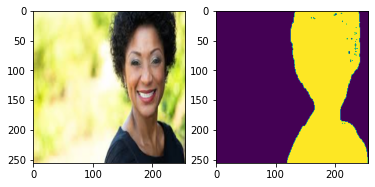

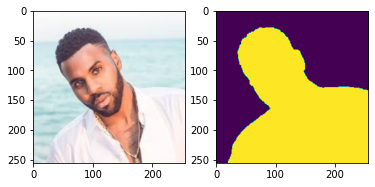

In [58]:
train_X = []
train_y = []
test_X = []
test_y = []

mask_path = os.path.join("Ground_Truth/")
images_path = os.path.join("Training_Images/")

filelist = os.listdir(images_path)
mask_names = []
for x in filelist[:-3]:
    if x.endswith(".jpg"):
        train_X.append(cv.cvtColor(cv.imread(images_path+x), cv.COLOR_BGR2RGB))
        train_X[-1] = cv.resize(train_X[-1], (IMG_HEIGHT, IMG_WIDTH))
        x = x[:-4] + '.png'
        train_y.append(cv.imread(mask_path+x, 0))
        train_y[-1] = cv.resize(train_y[-1], (IMG_HEIGHT, IMG_WIDTH))
        _, train_y[-1] = cv.threshold(train_y[-1], int(0.5*255), 255, cv.THRESH_BINARY)

for x in filelist[-3:]:
    if x.endswith(".jpg"):
        test_X.append(cv.cvtColor(cv.imread(images_path+x), cv.COLOR_BGR2RGB))
        test_X[-1] = cv.resize(test_X[-1], (IMG_HEIGHT, IMG_WIDTH))
        x = x[:-4] + '.png'
        test_y.append(cv.imread(mask_path+x, 0))
        test_y[-1] = cv.resize(test_y[-1], (IMG_HEIGHT, IMG_WIDTH))
        _, test_y[-1] = cv.threshold(test_y[-1], int(0.5*255), 255, cv.THRESH_BINARY)



train_X = np.array(train_X)
train_y = np.array(train_y)/255.0
test_X = np.array(test_X)
test_y = np.array(test_y)/255.0

fig, ax = plt.subplots(1,2)
ax[0].imshow(train_X[0])
ax[1].imshow(train_y[0])
plt.show()
fig, ax = plt.subplots(1,2)
ax[0].imshow(test_X[0])
ax[1].imshow(test_y[0])
plt.show()

**U-Net based on original paper.**

In [59]:
with tpu_strategy.scope():
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  # Contraction path
  c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.1)(c3)
  c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.1)(c4)
  c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.1)(c5)
  c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  # Expansive path
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.1)(c6)
  c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.1)(c7)
  c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  plot_model(model)
  model.summary()
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True)
  history = model.fit(train_X, train_y, batch_size=20, epochs=80, validation_split=0.1, callbacks=callback)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 256, 256, 32) 896         lambda_6[0][0]                   
__________________________________________________________________________________________________
dropout_54 (Dropout)            (None, 256, 256, 32) 0           conv2d_114[0][0]                 
____________________________________________________________________________________________

**History of training.**

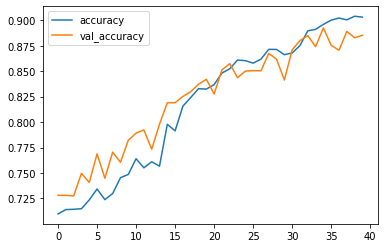

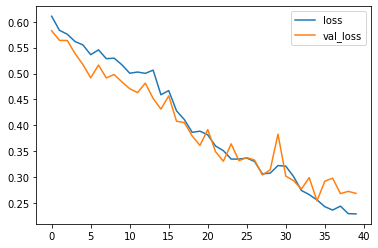

In [60]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

**Checking the results on test images.**

You can try with and without thresholded predictions. I prefer without option as it carries more information.

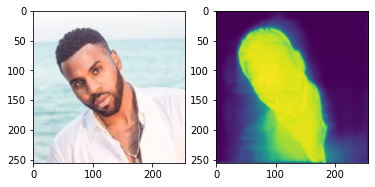

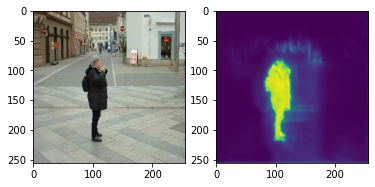

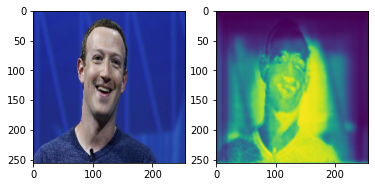

In [61]:
for i in range(len(test_X)):
    shape = test_X[i].shape
    prediction = model.predict(test_X[i].reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    prediction = np.squeeze(prediction)
    test_X[i] = np.squeeze(test_X[i])
    
    prediction = prediction * 255.0

    prediction = prediction.astype(np.uint8)
    test_X[i]= test_X[i].astype(np.uint8)
    
    # _, prediction = cv.threshold(prediction, int(0.7*255), 255, cv.THRESH_BINARY)

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(test_X[i])
    ax[1].imshow(prediction)
    plt.show()

**Colab's sample function to take photo from the camera**

In [62]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

**Checking the results on Your own picture.**

In [ ]:
from PIL import Image
# frame = vs.read()
frame = take_photo()
if frame is None:
    print('frame is none')
else:
  frame = np.asarray(Image.open(frame))
  frame = cv.resize(frame, (IMG_HEIGHT, IMG_WIDTH)).reshape(-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
  prediction = model.predict(frame)
  frame = np.squeeze(frame)
  prediction = np.squeeze(prediction)
  prediction = prediction * 255.0
  # _, prediction = cv.threshold(prediction, int(0.8 * 255), 255, cv.THRESH_BINARY)
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(frame)
  ax[1].imshow(prediction)
  plt.show()

## Conclusion

Dataset used in this project is very small, esspecially considering segmentation problem.

Results are acceptable. Better accuracy might be get using bigger dataset and bigger model. Also data augmentation is the thing to consider.

Hope You liked it :)